In [12]:
import numpy as np
from scipy.special import expit  # inverse logit
import json

np.random.seed(42)

# Dimensions
N = 500            # Number of observations
n_language = 3     # Number of language levels
n_metric = 2       # Number of metric levels
n_task = 4         # Number of task levels

# True parameter values
alpha = 0.5
phi = 10.0  # precision parameter

# Simulate raw coefficients and then enforce sum-to-zero constraint
beta_language_raw = np.random.normal(0, 2.0, size=n_language - 1)
beta_language = np.concatenate([beta_language_raw, [-beta_language_raw.sum()]])

beta_metric_raw = np.random.normal(0, 2.0, size=n_metric - 1)
beta_metric = np.concatenate([beta_metric_raw, [-beta_metric_raw.sum()]])

beta_task_raw = np.random.normal(0, 2.0, size=n_task - 1)
beta_task = np.concatenate([beta_task_raw, [-beta_task_raw.sum()]])

# Simulate categorical predictor indices (values between 1 and n_level)
language = np.random.randint(1, n_language + 1, size=N)
metric   = np.random.randint(1, n_metric + 1, size=N)
task     = np.random.randint(1, n_task + 1, size=N)

# Compute linear predictor using the sum-to-zero constrained coefficients.
# Note that indices in Python are zero-indexed.
logit_mu = (alpha +
            np.array([beta_language[l - 1] for l in language]) +
            np.array([beta_metric[m - 1] for m in metric]) +
            np.array([beta_task[t - 1] for t in task]))

mu = expit(logit_mu)

# Simulate outcome from Beta(mu * phi, (1-mu) * phi)
# np.random.beta requires shape parameters > 0.
y = np.array([np.random.beta(a=mu_i * phi, b=(1 - mu_i) * phi) for mu_i in mu])

# if y = 1 then replace with 0.999
y[y == 1] = 0.999

# Package simulated data into a dictionary in the Stan data format.
data = {
    'N': int(N),
    'n_language': int(n_language),
    'n_metric': int(n_metric),
    'n_task': int(n_task),
    'language': language.tolist(),
    'metric': metric.tolist(),
    'task': task.tolist(),
    'y': y.tolist()
}

# Optionally, save the simulated data to a JSON file
# with open("simulated_simple_index_data.json", "w") as f:
#     json.dump(data, f, indent=2)

# print("Simulated data saved to simulated_simple_index_data.json")

In [16]:
from cmdstanpy import CmdStanModel

stan_file = "../models/simple/simple_index_variable_sumtozero.stan"

# Compile the Stan model using cmdstanpy.
model = CmdStanModel(stan_file=stan_file)

# Fit the model using MCMC sampling.
fit = model.sample(
    data=data,
    chains=4,
    iter_sampling=2000,
    iter_warmup=1000,
    seed=42,
    # output_dir='output',
    # show_console=True,
)

15:43:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:43:30 - cmdstanpy - INFO - CmdStan done processing.


In [17]:
fit.summary()

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,934.426000,0.033245,2.007460,1.889570,930.704000,934.737000,937.086000,3774.61,5074.88,1.001090
alpha,0.501190,0.000367,0.035980,0.035893,0.441514,0.501200,0.559669,9658.84,5564.04,1.000590
beta_language_raw[1],0.909064,0.000629,0.052632,0.051940,0.821121,0.910189,0.994733,7034.76,6523.50,0.999845
beta_language_raw[2],-0.236066,0.000536,0.049413,0.050013,-0.317818,-0.235978,-0.154450,8543.91,6755.31,1.000040
beta_metric_raw[1],1.224850,0.000431,0.039571,0.040727,1.158850,1.224700,1.290290,8418.68,6215.54,1.000150
...,...,...,...,...,...,...,...,...,...,...
mu[496],0.658731,0.000220,0.019973,0.020045,0.625587,0.658910,0.691328,8309.22,6765.67,0.999967
mu[497],0.899094,0.000088,0.008256,0.008286,0.885267,0.899404,0.912179,8816.58,6576.45,1.000200
mu[498],0.981152,0.000027,0.002099,0.002079,0.977496,0.981251,0.984391,6171.75,6129.50,1.000210
mu[499],0.874575,0.000123,0.010865,0.011068,0.855923,0.874895,0.891579,7886.04,6607.99,1.000410


In [18]:
import arviz as az

cmdstanpy_data = az.from_cmdstanpy(
    posterior=fit,
    # posterior_predictive="y_hat",
    observed_data={"y": data["y"]},
    # log_likelihood="log_lik",
    # coords={"language": np.arange(data["language"])},
    # dims={
    #     "theta": ["school"],
    #     "y": ["school"],
    #     "log_lik": ["school"],
    #     "y_hat": ["school"],
    #     "theta_tilde": ["school"],
    # },
)
cmdstanpy_data

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([[<Axes: title={'center': 'beta_language'}>,
        <Axes: title={'center': 'beta_language'}>]], dtype=object)

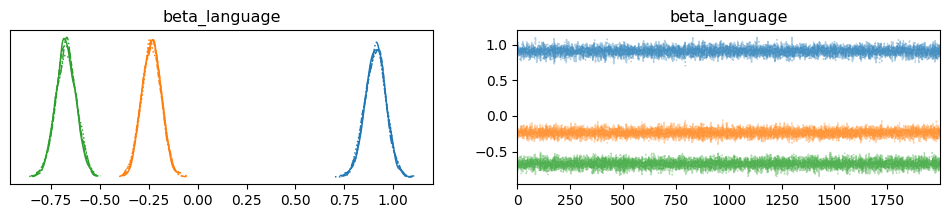

In [21]:
az.plot_trace(cmdstanpy_data, var_names=("beta_language"))

array([<Axes: title={'center': '94.0% HDI'}>,
       <Axes: title={'center': 'ess'}>], dtype=object)

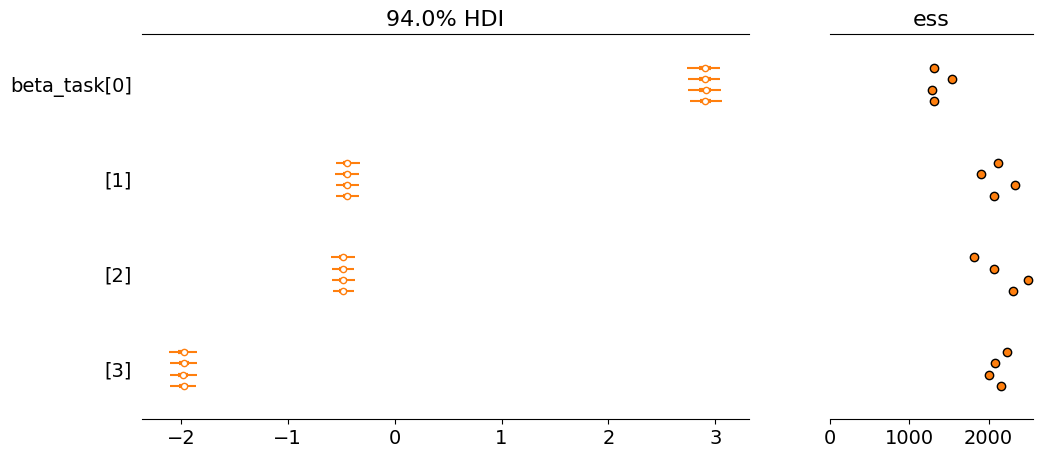

In [26]:
az.plot_forest(
    cmdstanpy_data,
    var_names=["beta_task"],
    figsize=(11.5, 5),
    colors="C1",
    ess=True,
    # r_hat=True,
)

array([ 3.04605971, -0.46830675, -0.46827391, -2.10947905])